
# Meta-Learning - Learning to Learn

* **Author:** Phillip Lippe
* **License:** CC BY-SA
* **Generated:** 2021-09-15T20:58:58.591846

In this tutorial, we will discuss algorithms that learn models which can quickly adapt to new classes and/or tasks with few samples.
This area of machine learning is called _Meta-Learning_ aiming at "learning to learn".
Learning from very few examples is a natural task for humans. In contrast to current deep learning models, we need to see only a few examples of a police car or firetruck to recognize them in daily traffic.
This is crucial ability since in real-world application, it is rarely the case that the data stays static and does not change over time.
For example, an object detection system for mobile phones trained on data from 2000 will have troubles detecting today's common mobile phones, and thus, needs to adapt to new data without excessive label effort.
The optimization techniques we have discussed so far struggle with this because they only aim at obtaining a good performance on a test set that had similar data.
However, what if the test set has classes that we do not have in the training set?
Or what if we want to test the model on a completely different task?
We will discuss and implement three common Meta-Learning algorithms for such situations.
This notebook is part of a lecture series on Deep Learning at the University of Amsterdam.
The full list of tutorials can be found at https://uvadlc-notebooks.rtfd.io.


---
Open in [Open In Colab{height="20px" width="117px"}](https://colab.research.google.com/github/PytorchLightning/lightning-tutorials/blob/publication/.notebooks/course_UvA-DL/meta-learning.ipynb)

Give us a ⭐ [on Github](https://www.github.com/PytorchLightning/pytorch-lightning/)
| Check out [the documentation](https://pytorch-lightning.readthedocs.io/en/latest/)
| Join us [on Slack](https://join.slack.com/t/pytorch-lightning/shared_invite/zt-pw5v393p-qRaDgEk24~EjiZNBpSQFgQ)

## Setup
This notebook requires some packages besides pytorch-lightning.

In [1]:
# ! pip install --quiet "torch>=1.6, <1.9" "matplotlib" "torchmetrics>=0.3" "seaborn" "torchvision" "pytorch-lightning>=1.3"

Meta-Learning offers solutions to these situations, and we will discuss three popular algorithms: __Prototypical Networks__ ([Snell et al., 2017](https://arxiv.org/pdf/1703.05175.pdf)), __Model-Agnostic Meta-Learning / MAML__ ([Finn et al., 2017](http://proceedings.mlr.press/v70/finn17a.html)), and __Proto-MAML__ ([Triantafillou et al., 2020](https://openreview.net/pdf?id=rkgAGAVKPr)).
We will focus on the task of few-shot classification where the training and test set have distinct sets of classes.
For instance, we would train the model on the binary classifications of cats-birds and flowers-bikes, but during test time, the model would need to learn from 4 examples each the difference between dogs and otters, two classes we have not seen during training (Figure credit - [Lilian Weng](https://lilianweng.github.io/lil-log/2018/11/30/meta-learning.html)).

<center width="100%"><img src="https://github.com/PyTorchLightning/lightning-tutorials/raw/main/course_UvA-DL/meta-learning/few-shot-classification.png" width="800px"></center>

A different setup, which is very common in Reinforcement Learning and recently Natural Language Processing, is to aim at few-shot learning of a completely new task.
For example, an robot agent that learned to run, jump and pick up boxes, should quickly adapt to collecting and stacking boxes.
In NLP, we can think of a model which was trained sentiment classification, hatespeech detection and sarcasm classification, to adapt to classifying the emotion of a text.
All methods we will discuss in this notebook can be easily applied to these settings since we only use a different definition of a 'task'.
For few-shot classification, we consider a task to distinguish between $M$ novel classes.
Here, we would not only have novel classes, but also a completely different dataset.

First of all, let's start with importing our standard libraries. We will again be using PyTorch Lightning.

In [2]:
import json
import os
import random
import urllib.request
from collections import defaultdict
from copy import deepcopy
from statistics import mean, stdev
from urllib.error import HTTPError

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl
import seaborn as sns
import torch
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision
from IPython.display import set_matplotlib_formats
from PIL import Image
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
from torchvision import transforms
from torchvision.datasets import CIFAR100, SVHN
from tqdm.auto import tqdm

plt.set_cmap("cividis")
# %matplotlib inline
set_matplotlib_formats("svg", "pdf")  # For export
matplotlib.rcParams["lines.linewidth"] = 2.0
sns.reset_orig()

# Import tensorboard
# %load_ext tensorboard

# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = os.environ.get("PATH_DATASETS", "data/")
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = os.environ.get("PATH_CHECKPOINT", "saved_models/MetaLearning/")

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

/tmp/ipykernel_1237/3072189054.py:29: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats("svg", "pdf")  # For export
Global seed set to 42


Device: cuda:0


<Figure size 432x288 with 0 Axes>

Training the models in this notebook can take between 2 and 8 hours, and the evaluation time of some algorithms is in the span of couples of minutes.
Hence, we download pre-trained models and results below.

In [3]:
# Github URL where saved models are stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial16/"
# Files to download
pretrained_files = [
    "ProtoNet.ckpt",
    "ProtoMAML.ckpt",
    "tensorboards/ProtoNet/events.out.tfevents.ProtoNet",
    "tensorboards/ProtoMAML/events.out.tfevents.ProtoMAML",
    "protomaml_fewshot.json",
    "protomaml_svhn_fewshot.json",
]
# Create checkpoint path if it doesn't exist yet
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for file_name in pretrained_files:
    file_path = os.path.join(CHECKPOINT_PATH, file_name)
    if "/" in file_name:
        os.makedirs(file_path.rsplit("/", 1)[0], exist_ok=True)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print("Downloading %s..." % file_url)
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print(
                "Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n",
                e,
            )

## Few-shot classification

We start our implementation by discussing the dataset setup.
In this notebook, we will use CIFAR100 which we have already seen in Tutorial 6.
CIFAR100 has 100 classes each with 600 images of size $32\times 32$ pixels.
Instead of splitting the training, validation and test set over examples, we will split them over classes: we will use 80 classes for training, and 10 for validation and 10 for testing.
Our overall goal is to obtain a model that can distinguish between the 10 test classes with seeing very little examples.
First, let's load the dataset and visualize some examples.

In [4]:
# Loading CIFAR100 dataset
cifar_train_set = CIFAR100(root=DATASET_PATH, train=True, download=True, transform=transforms.ToTensor())
cifar_test_set = CIFAR100(root=DATASET_PATH, train=False, download=True, transform=transforms.ToTensor())

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting /__w/1/s/.datasets/cifar-100-python.tar.gz to /__w/1/s/.datasets


Files already downloaded and verified


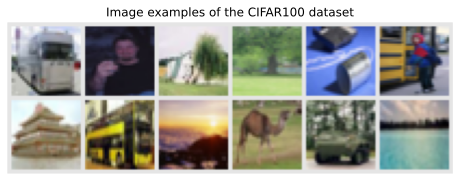

In [5]:
# Visualize some examples
NUM_IMAGES = 12
cifar_images = [cifar_train_set[np.random.randint(len(cifar_train_set))][0] for idx in range(NUM_IMAGES)]
cifar_images = torch.stack(cifar_images, dim=0)
img_grid = torchvision.utils.make_grid(cifar_images, nrow=6, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8, 8))
plt.title("Image examples of the CIFAR100 dataset")
plt.imshow(img_grid)
plt.axis("off")
plt.show()
plt.close()

### Data preprocessing

Next, we need to prepare the dataset in the training, validation and test split as mentioned before.
The torchvision package gives us the training and test set as two separate dataset objects.
The next code cells will merge the original training and test set, and then create the new train-val-test split.

In [6]:
# Merging original training and test set
cifar_all_images = np.concatenate([cifar_train_set.data, cifar_test_set.data], axis=0)
cifar_all_targets = torch.LongTensor(cifar_train_set.targets + cifar_test_set.targets)

To have an easier time handling the dataset, we define our own, simple dataset class below.
It takes a set of images, labels/targets, and image transformations, and
returns the corresponding images and labels element-wise.

In [7]:
class ImageDataset(data.Dataset):
    def __init__(self, imgs, targets, img_transform=None):
        """
        Inputs:
            imgs - Numpy array of shape [N,32,32,3] containing all images.
            targets - PyTorch array of shape [N] containing all labels.
            img_transform - A torchvision transformation that should be applied
                            to the images before returning. If none, no transformation
                            is applied.
        """
        super().__init__()
        self.img_transform = img_transform
        self.imgs = imgs
        self.targets = targets

    def __getitem__(self, idx):
        img, target = self.imgs[idx], self.targets[idx]
        img = Image.fromarray(img)

        if self.img_transform is not None:
            img = self.img_transform(img)

        return img, target

    def __len__(self):
        return self.imgs.shape[0]

Now, we can create the class splits.
We will assign the classes randomly to training, validation and test, and use a 80%-10%-10% split.

In [8]:
pl.seed_everything(0)  # Set seed for reproducibility
classes = torch.randperm(100)  # Returns random permutation of numbers 0 to 99
train_classes, val_classes, test_classes = classes[:80], classes[80:90], classes[90:]

Global seed set to 0


To get an intuition of the validation and test classes, we print the class names below:

In [9]:
# Printing validation and test classes
idx_to_class = {val: key for key, val in cifar_train_set.class_to_idx.items()}
print("Validation classes:", [idx_to_class[c.item()] for c in val_classes])
print("Test classes:", [idx_to_class[c.item()] for c in test_classes])

Validation classes: ['caterpillar', 'castle', 'skunk', 'ray', 'bus', 'motorcycle', 'keyboard', 'chimpanzee', 'possum', 'tiger']
Test classes: ['kangaroo', 'crocodile', 'butterfly', 'shark', 'forest', 'pickup_truck', 'telephone', 'lion', 'worm', 'mushroom']


As we can see, the classes have quite some variety and some classes might be easier to distinguish than others.
For instance, in the test classes, 'pickup_truck' is the only vehicle while the classes 'mushroom', 'worm' and 'forest' might be harder to keep apart.
Remember that we want to learn the classification of those ten classes from 80 other classes in our training set, and few examples from the actual test classes.
We will experiment with the number of examples per class.

Finally, we can create the training, validation and test dataset according to our split above.
For this, we create dataset objects of our previously defined class `ImageDataset`.

In [10]:
def dataset_from_labels(imgs, targets, class_set, **kwargs):
    class_mask = (targets[:, None] == class_set[None, :]).any(dim=-1)
    return ImageDataset(imgs=imgs[class_mask], targets=targets[class_mask], **kwargs)

As in our experiments before on CIFAR in Tutorial 5, 6 and 9, we normalize the dataset.
Additionally, we use small augmentations during training to prevent overfitting.

In [11]:
DATA_MEANS = (cifar_train_set.data / 255.0).mean(axis=(0, 1, 2))
DATA_STD = (cifar_train_set.data / 255.0).std(axis=(0, 1, 2))

test_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(DATA_MEANS, DATA_STD)])
# For training, we add some augmentation.
train_transform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop((32, 32), scale=(0.8, 1.0), ratio=(0.9, 1.1)),
        transforms.ToTensor(),
        transforms.Normalize(DATA_MEANS, DATA_STD),
    ]
)

train_set = dataset_from_labels(cifar_all_images, cifar_all_targets, train_classes, img_transform=train_transform)
val_set = dataset_from_labels(cifar_all_images, cifar_all_targets, val_classes, img_transform=test_transform)
test_set = dataset_from_labels(cifar_all_images, cifar_all_targets, test_classes, img_transform=test_transform)

### Data sampling

The strategy of how to use the available training data for learning few-shot adaptation is crucial in meta-learning.
All three algorithms that we discuss here have a similar idea: simulate few-shot learning during training.
Specifically, at each training step, we randomly select a small number of classes, and sample a small number of examples for each class.
This represents our few-shot training batch, which we also refer to as **support set**.
Additionally, we sample a second set of examples from the same classes, and refer to this batch as **query set**.
Our training objective is to classify the query set correctly from seeing the support set and its corresponding labels.
The main difference between our three methods (ProtoNet, MAML, and Proto-MAML) is in how they use the support set to adapt to the training classes.

This subsection summarizes the code that is needed to create such training batches.
In PyTorch, we can specify the data sampling procedure by so-called `Sampler` ([documentation](https://pytorch.org/docs/stable/data.html#data-loading-order-and-sampler)).
Samplers are iteratable objects that return indices in the order in which the data elements should be sampled.
In our previous notebooks, we usually used the option `shuffle=True` in the `data.DataLoader` objects which creates a sampler returning the data indices in a random order.
Here, we focus on samplers that return batches of indices that correspond to support and query set batches.
Below, we implement such a sampler.

In [12]:
class FewShotBatchSampler:
    def __init__(self, dataset_targets, N_way, K_shot, include_query=False, shuffle=True, shuffle_once=False):
        """
        Inputs:
            dataset_targets - PyTorch tensor of the labels of the data elements.
            N_way - Number of classes to sample per batch.
            K_shot - Number of examples to sample per class in the batch.
            include_query - If True, returns batch of size N_way*K_shot*2, which
                            can be split into support and query set. Simplifies
                            the implementation of sampling the same classes but
                            distinct examples for support and query set.
            shuffle - If True, examples and classes are newly shuffled in each
                      iteration (for training)
            shuffle_once - If True, examples and classes are shuffled once in
                           the beginning, but kept constant across iterations
                           (for validation)
        """
        super().__init__()
        self.dataset_targets = dataset_targets
        self.N_way = N_way
        self.K_shot = K_shot
        self.shuffle = shuffle
        self.include_query = include_query
        if self.include_query:
            self.K_shot *= 2
        self.batch_size = self.N_way * self.K_shot  # Number of overall images per batch

        # Organize examples by class
        self.classes = torch.unique(self.dataset_targets).tolist()
        self.num_classes = len(self.classes)
        self.indices_per_class = {}
        self.batches_per_class = {}  # Number of K-shot batches that each class can provide
        for c in self.classes:
            self.indices_per_class[c] = torch.where(self.dataset_targets == c)[0]
            self.batches_per_class[c] = self.indices_per_class[c].shape[0] // self.K_shot

        # Create a list of classes from which we select the N classes per batch
        self.iterations = sum(self.batches_per_class.values()) // self.N_way
        self.class_list = [c for c in self.classes for _ in range(self.batches_per_class[c])]
        if shuffle_once or self.shuffle:
            self.shuffle_data()
        else:
            # For testing, we iterate over classes instead of shuffling them
            sort_idxs = [
                i + p * self.num_classes for i, c in enumerate(self.classes) for p in range(self.batches_per_class[c])
            ]
            self.class_list = np.array(self.class_list)[np.argsort(sort_idxs)].tolist()

    def shuffle_data(self):
        # Shuffle the examples per class
        for c in self.classes:
            perm = torch.randperm(self.indices_per_class[c].shape[0])
            self.indices_per_class[c] = self.indices_per_class[c][perm]
        # Shuffle the class list from which we sample. Note that this way of shuffling
        # does not prevent to choose the same class twice in a batch. However, for
        # training and validation, this is not a problem.
        random.shuffle(self.class_list)

    def __iter__(self):
        # Shuffle data
        if self.shuffle:
            self.shuffle_data()

        # Sample few-shot batches
        start_index = defaultdict(int)
        for it in range(self.iterations):
            class_batch = self.class_list[it * self.N_way : (it + 1) * self.N_way]  # Select N classes for the batch
            index_batch = []
            for c in class_batch:  # For each class, select the next K examples and add them to the batch
                index_batch.extend(self.indices_per_class[c][start_index[c] : start_index[c] + self.K_shot])
                start_index[c] += self.K_shot
            if self.include_query:  # If we return support+query set, sort them so that they are easy to split
                index_batch = index_batch[::2] + index_batch[1::2]
            yield index_batch

    def __len__(self):
        return self.iterations

Now, we can create our intended data loaders by passing an object of `FewShotBatchSampler` as `batch_sampler=...` input to the PyTorch data loader object.
For our experiments, we will use a 5-class 4-shot training setting.
This means that each support set contains 5 classes with 4 examples each, i.e., 20 images overall.
Usually, it is good to keep the number of shots equal to the number that you aim to test on.
However, we will experiment later with different number of shots, and hence, we pick 4 as a compromise for now.
To get the best performing model, it is recommended to consider the
number of training shots as hyperparameter in a grid search.

In [13]:
N_WAY = 5
K_SHOT = 4
train_data_loader = data.DataLoader(
    train_set,
    batch_sampler=FewShotBatchSampler(train_set.targets, include_query=True, N_way=N_WAY, K_shot=K_SHOT, shuffle=True),
    num_workers=4,
)
val_data_loader = data.DataLoader(
    val_set,
    batch_sampler=FewShotBatchSampler(
        val_set.targets, include_query=True, N_way=N_WAY, K_shot=K_SHOT, shuffle=False, shuffle_once=True
    ),
    num_workers=4,
)

For simplicity, we implemented the sampling of a support and query set as sampling a support set with twice the number of examples.
After sampling a batch from the data loader, we need to split it into a support and query set.
We can summarize this step in the following function:

In [14]:
def split_batch(imgs, targets):
    support_imgs, query_imgs = imgs.chunk(2, dim=0)
    support_targets, query_targets = targets.chunk(2, dim=0)
    return support_imgs, query_imgs, support_targets, query_targets

Finally, to ensure that our implementation of the data sampling process is correct, we can sample a batch and visualize its support and query set.
What we would like to see is that the support and query set have the same classes, but distinct examples.

In [15]:
imgs, targets = next(iter(val_data_loader))  # We use the validation set since it does not apply augmentations
support_imgs, query_imgs, _, _ = split_batch(imgs, targets)
support_grid = torchvision.utils.make_grid(support_imgs, nrow=K_SHOT, normalize=True, pad_value=0.9)
support_grid = support_grid.permute(1, 2, 0)
query_grid = torchvision.utils.make_grid(query_imgs, nrow=K_SHOT, normalize=True, pad_value=0.9)
query_grid = query_grid.permute(1, 2, 0)

fig, ax = plt.subplots(1, 2, figsize=(8, 5))
ax[0].imshow(support_grid)
ax[0].set_title("Support set")
ax[0].axis("off")
ax[1].imshow(query_grid)
ax[1].set_title("Query set")
ax[1].axis("off")
fig.suptitle("Few Shot Batch", weight="bold")
fig.show()
plt.close(fig)

As we can see, the support and query set have the same five classes, but different examples.
The models will be tasked to classify the examples in the query set by learning from the support set and its labels.
With the data sampling in place, we can now start to implement our first meta-learning model: Prototypical Networks.

## Prototypical Networks

The Prototypical Network, or ProtoNet for short, is a metric-based meta-learning algorithm which operates similar to a nearest neighbor classification.
Metric-based meta-learning methods classify a new example $\mathbf{x}$ based on some distance function $d_{\varphi}$ between $x$ and all elements in the support set.
ProtoNets implements this idea with the concept of prototypes in a learned feature space.
First, ProtoNet uses an embedding function $f_{\theta}$ to encode each input in the support set into a $L$-dimensional feature vector.
Next, for each class $c$, we collect the feature vectors of all examples with label $c$, and average their feature vectors.
Formally, we can define this as:

$$\mathbf{v}_c=\frac{1}{|S_c|}\sum_{(\mathbf{x}_i,y_i)\in S_c}f_{\theta}(\mathbf{x}_i)$$

where $S_c$ is the part of the support set $S$ for which $y_i=c$, and $\mathbf{v}_c$ represents the _prototype_ of class $c$.
The prototype calculation is visualized below for a 2-dimensional feature space and 3 classes (Figure credit - [Snell et al.](https://arxiv.org/pdf/1703.05175.pdf)).
The colored dots represent encoded support elements with color-corresponding class label, and the black dots next to the class label are the averaged prototypes.

<center width="100%"><img src="https://github.com/PyTorchLightning/lightning-tutorials/raw/main/course_UvA-DL/meta-learning/protonet_classification.svg" width="300px"></center>

Based on these prototypes, we want to classify a new example.
Remember that since we want to learn the encoding function $f_{\theta}$, this classification must be differentiable and hence, we need to define a probability distribution across classes.
For this, we will make use of the distance function $d_{\varphi}$: the closer a new example $\mathbf{x}$ is to a prototype $\mathbf{v}_c$, the higher the probability for $\mathbf{x}$ belonging to class $c$.
Formally, we can simply use a softmax over the distances of $\mathbf{x}$ to all class prototypes:

$$p(y=c\vert\mathbf{x})=\text{softmax}(-d_{\varphi}(f_{\theta}(\mathbf{x}), \mathbf{v}_c))=\frac{\exp\left(-d_{\varphi}(f_{\theta}(\mathbf{x}), \mathbf{v}_c)\right)}{\sum_{c'\in \mathcal{C}}\exp\left(-d_{\varphi}(f_{\theta}(\mathbf{x}), \mathbf{v}_{c'})\right)}$$

Note that the negative sign is necessary since we want to increase the probability for close-by vectors and have a low probability for distant vectors.
We train the network $f_{\theta}$ based on the cross entropy error of the training query set examples.
Thereby, the gradient flows through both the prototypes $\mathbf{v}_c$ and the query set encodings $f_{\theta}(\mathbf{x})$.
For the distance function $d_{\varphi}$, we can choose any function as long as it is differentiable with respect to both of its inputs.
The most common function, which we also use here, is the squared
euclidean distance, but there has been several works on different
distance functions as well.

### ProtoNet implementation

Now that we know how a ProtoNet works in principle, let's look at how we can apply to our specific problem of few-shot image classification, and implement it below.
First, we need to define the encoder function $f_{\theta}$.
Since we work with CIFAR images, we can take a look back at Tutorial 5 where we compared common Computer Vision architectures, and choose one of the best performing ones.
Here, we go with a DenseNet since it is in general more parameter efficient than ResNet.
Luckily, we do not need to implement DenseNet ourselves again and can rely on torchvision's model package instead.
We use common hyperparameters of 64 initial feature channels, add 32 per block, and use a bottleneck size of 64 (i.e. 2 times the growth rate).
We use 4 stages of 6 layers each, which results in overall about 1 million parameters.
Note that the torchvision package assumes that the last layer is used for classification and hence calls its output size `num_classes`.
However, we can instead just use it as the feature space of ProtoNet, and choose an arbitrary dimensionality.
We will use the same network for other algorithms in this notebook to ensure a fair comparison.

In [16]:
def get_convnet(output_size):
    convnet = torchvision.models.DenseNet(
        growth_rate=32,
        block_config=(6, 6, 6, 6),
        bn_size=2,
        num_init_features=64,
        num_classes=output_size,  # Output dimensionality
    )
    return convnet

Next, we can look at implementing ProtoNet.
We will define it as PyTorch Lightning module to use all functionalities of PyTorch Lightning.
The first step during training is to encode all images in a batch with our network.
Next, we calculate the class prototypes from the support set (function `calculate_prototypes`), and classify the query set examples according to the prototypes (function `classify_feats`).
Keep in mind that we use the data sampling described before, such that the support and query set are stacked together in the batch.
Thus, we use our previously defined function `split_batch` to split them apart.
The full code can be found below.

In [17]:
class ProtoNet(pl.LightningModule):
    def __init__(self, proto_dim, lr):
        """Inputs.

        proto_dim - Dimensionality of prototype feature space
        lr - Learning rate of Adam optimizer
        """
        super().__init__()
        self.save_hyperparameters()
        self.model = get_convnet(output_size=self.hparams.proto_dim)

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.hparams.lr)
        scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[140, 180], gamma=0.1)
        return [optimizer], [scheduler]

    @staticmethod
    def calculate_prototypes(features, targets):
        # Given a stack of features vectors and labels, return class prototypes
        # features - shape [N, proto_dim], targets - shape [N]
        classes, _ = torch.unique(targets).sort()  # Determine which classes we have
        prototypes = []
        for c in classes:
            p = features[torch.where(targets == c)[0]].mean(dim=0)  # Average class feature vectors
            prototypes.append(p)
        prototypes = torch.stack(prototypes, dim=0)
        # Return the 'classes' tensor to know which prototype belongs to which class
        return prototypes, classes

    def classify_feats(self, prototypes, classes, feats, targets):
        # Classify new examples with prototypes and return classification error
        dist = torch.pow(prototypes[None, :] - feats[:, None], 2).sum(dim=2)  # Squared euclidean distance
        preds = F.log_softmax(-dist, dim=1)
        labels = (classes[None, :] == targets[:, None]).long().argmax(dim=-1)
        acc = (preds.argmax(dim=1) == labels).float().mean()
        return preds, labels, acc

    def calculate_loss(self, batch, mode):
        # Determine training loss for a given support and query set
        imgs, targets = batch
        features = self.model(imgs)  # Encode all images of support and query set
        support_feats, query_feats, support_targets, query_targets = split_batch(features, targets)
        prototypes, classes = ProtoNet.calculate_prototypes(support_feats, support_targets)
        preds, labels, acc = self.classify_feats(prototypes, classes, query_feats, query_targets)
        loss = F.cross_entropy(preds, labels)

        self.log("%s_loss" % mode, loss)
        self.log("%s_acc" % mode, acc)
        return loss

    def training_step(self, batch, batch_idx):
        return self.calculate_loss(batch, mode="train")

    def validation_step(self, batch, batch_idx):
        self.calculate_loss(batch, mode="val")

For validation, we use the same principle as training and sample support and query sets from the hold-out 10 classes.
However, this gives us noisy scores depending on which query sets are chosen to which support sets.
This is why we will use a different strategy during testing.
For validation, our training strategy is sufficient since it is much
faster than testing, and gives a good estimate of the training
generalization as long as we keep the support-query sets constant across
validation iterations.

### Training

After implementing the model, we can already start training it.
We use our common PyTorch Lightning training function, and train the model for 200 epochs.
The training function takes `model_class` as input argument, i.e. the
PyTorch Lightning module class that should be trained, since we will
reuse this function for other algorithms as well.

In [18]:
def train_model(model_class, train_loader, val_loader, **kwargs):
    trainer = pl.Trainer(
        default_root_dir=os.path.join(CHECKPOINT_PATH, model_class.__name__),
        gpus=1 if str(device) == "cuda:0" else 0,
        max_epochs=200,
        callbacks=[
            ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc"),
            LearningRateMonitor("epoch"),
        ],
        progress_bar_refresh_rate=0,
    )
    trainer.logger._default_hp_metric = None

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, model_class.__name__ + ".ckpt")
    if os.path.isfile(pretrained_filename):
        print("Found pretrained model at %s, loading..." % pretrained_filename)
        # Automatically loads the model with the saved hyperparameters
        model = model_class.load_from_checkpoint(pretrained_filename)
    else:
        pl.seed_everything(42)  # To be reproducable
        model = model_class(**kwargs)
        trainer.fit(model, train_loader, val_loader)
        model = model_class.load_from_checkpoint(
            trainer.checkpoint_callback.best_model_path
        )  # Load best checkpoint after training

    return model

Below is the training call for our ProtoNet.
We use a 64-dimensional feature space.
Larger feature spaces showed to give noisier results since the squared euclidean distance becomes proportionally larger in expectation, and smaller feature spaces might not allow for enough flexibility.
We recommend to load the pre-trained model here at first, but feel free
to play around with the hyperparameters yourself.

In [19]:
protonet_model = train_model(
    ProtoNet, proto_dim=64, lr=2e-4, train_loader=train_data_loader, val_loader=val_data_loader
)

GPU available: True, used: True


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


Found pretrained model at saved_models/MetaLearning/ProtoNet.ckpt, loading...


We can also take a closer look at the TensorBoard below.

In [20]:
# Opens tensorboard in notebook. Adjust the path to your CHECKPOINT_PATH if needed
# # %tensorboard --logdir ../saved_models/tutorial16/tensorboards/ProtoNet/

<center width="100%"><img src="https://github.com/PyTorchLightning/lightning-tutorials/raw/main/course_UvA-DL/meta-learning/tensorboard_screenshot_ProtoNet.png" width="1100px"></center>

In contrast to standard supervised learning, we see that ProtoNet does not overfit as much as we would expect.
The validation accuracy is of course lower than the average training, but the training loss does not stick close to zero.
This is because no training batch is as the other, and we also mix new examples in the support set and query set.
This gives us slightly different prototypes in every iteration, and makes it harder for the network to fully overfit.

### Testing

Our goal of meta-learning is to obtain a model that can quickly adapt to a new task, or in this case, new classes to distinguish between.
To test this, we will use our trained ProtoNet and adapt it to the 10 test classes.
Thereby, we pick $k$ examples per class from which we determine the prototypes, and test the classification accuracy on all other examples.
This can be seen as using the $k$ examples per class as support set, and the rest of the dataset as a query set.
We iterate through the dataset such that each example has been once included in a support set.
The average performance over all support sets tells us how well we can expect ProtoNet to perform when seeing only $k$ examples per class.
During training, we used $k=4$.
In testing, we will experiment with $k=\{2,4,8,16,32\}$ to get a better sense of how $k$ influences the results.
We would expect that we achieve higher accuracies the more examples we have in the support set, but we don't know how it scales.
Hence, let's first implement a function that executes the testing procedure for a given $k$:

In [21]:
@torch.no_grad()
def test_proto_net(model, dataset, data_feats=None, k_shot=4):
    """Inputs.

    model - Pretrained ProtoNet model
    dataset - The dataset on which the test should be performed.
              Should be instance of ImageDataset
    data_feats - The encoded features of all images in the dataset.
                 If None, they will be newly calculated, and returned
                 for later usage.
    k_shot - Number of examples per class in the support set.
    """
    model = model.to(device)
    model.eval()
    num_classes = dataset.targets.unique().shape[0]
    exmps_per_class = dataset.targets.shape[0] // num_classes  # We assume uniform example distribution here

    # The encoder network remains unchanged across k-shot settings. Hence, we only need
    # to extract the features for all images once.
    if data_feats is None:
        # Dataset preparation
        dataloader = data.DataLoader(dataset, batch_size=128, num_workers=4, shuffle=False, drop_last=False)

        img_features = []
        img_targets = []
        for imgs, targets in tqdm(dataloader, "Extracting image features", leave=False):
            imgs = imgs.to(device)
            feats = model.model(imgs)
            img_features.append(feats.detach().cpu())
            img_targets.append(targets)
        img_features = torch.cat(img_features, dim=0)
        img_targets = torch.cat(img_targets, dim=0)
        # Sort by classes, so that we obtain tensors of shape [num_classes, exmps_per_class, ...]
        # Makes it easier to process later
        img_targets, sort_idx = img_targets.sort()
        img_targets = img_targets.reshape(num_classes, exmps_per_class).transpose(0, 1)
        img_features = img_features[sort_idx].reshape(num_classes, exmps_per_class, -1).transpose(0, 1)
    else:
        img_features, img_targets = data_feats

    # We iterate through the full dataset in two manners. First, to select the k-shot batch.
    # Second, the evaluate the model on all other examples
    accuracies = []
    for k_idx in tqdm(range(0, img_features.shape[0], k_shot), "Evaluating prototype classification", leave=False):
        # Select support set and calculate prototypes
        k_img_feats = img_features[k_idx : k_idx + k_shot].flatten(0, 1)
        k_targets = img_targets[k_idx : k_idx + k_shot].flatten(0, 1)
        prototypes, proto_classes = model.calculate_prototypes(k_img_feats, k_targets)
        # Evaluate accuracy on the rest of the dataset
        batch_acc = 0
        for e_idx in range(0, img_features.shape[0], k_shot):
            if k_idx == e_idx:  # Do not evaluate on the support set examples
                continue
            e_img_feats = img_features[e_idx : e_idx + k_shot].flatten(0, 1)
            e_targets = img_targets[e_idx : e_idx + k_shot].flatten(0, 1)
            _, _, acc = model.classify_feats(prototypes, proto_classes, e_img_feats, e_targets)
            batch_acc += acc.item()
        batch_acc /= img_features.shape[0] // k_shot - 1
        accuracies.append(batch_acc)

    return (mean(accuracies), stdev(accuracies)), (img_features, img_targets)

Testing ProtoNet is relatively quick if we have processed all images once. Hence, we can do in this notebook:

In [22]:
protonet_accuracies = dict()
data_feats = None
for k in [2, 4, 8, 16, 32]:
    protonet_accuracies[k], data_feats = test_proto_net(protonet_model, test_set, data_feats=data_feats, k_shot=k)
    print(
        "Accuracy for k=%i: %4.2f%% (+-%4.2f%%)"
        % (k, 100.0 * protonet_accuracies[k][0], 100 * protonet_accuracies[k][1])
    )

Extracting image features:   0%|          | 0/47 [00:00<?, ?it/s]

Evaluating prototype classification:   0%|          | 0/300 [00:00<?, ?it/s]

Accuracy for k=2: 44.30% (+-3.63%)


Evaluating prototype classification:   0%|          | 0/150 [00:00<?, ?it/s]

Accuracy for k=4: 52.07% (+-2.27%)


Evaluating prototype classification:   0%|          | 0/75 [00:20<?, ?it/s]

Accuracy for k=8: 57.59% (+-1.30%)


Evaluating prototype classification:   0%|          | 0/38 [00:00<?, ?it/s]

Accuracy for k=16: 62.56% (+-1.02%)


Evaluating prototype classification:   0%|          | 0/19 [00:00<?, ?it/s]

Accuracy for k=32: 66.49% (+-0.87%)


Before discussing the results above, let's first plot the accuracies over number of examples in the support set:

In [23]:
def plot_few_shot(acc_dict, name, color=None, ax=None):
    sns.set()
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 3))
    ks = sorted(list(acc_dict.keys()))
    mean_accs = [acc_dict[k][0] for k in ks]
    std_accs = [acc_dict[k][1] for k in ks]
    ax.plot(ks, mean_accs, marker="o", markeredgecolor="k", markersize=6, label=name, color=color)
    ax.fill_between(
        ks,
        [m - s for m, s in zip(mean_accs, std_accs)],
        [m + s for m, s in zip(mean_accs, std_accs)],
        alpha=0.2,
        color=color,
    )
    ax.set_xticks(ks)
    ax.set_xlim([ks[0] - 1, ks[-1] + 1])
    ax.set_xlabel("Number of shots per class", weight="bold")
    ax.set_ylabel("Accuracy", weight="bold")
    if len(ax.get_title()) == 0:
        ax.set_title("Few-Shot Performance " + name, weight="bold")
    else:
        ax.set_title(ax.get_title() + " and " + name, weight="bold")
    ax.legend()
    return ax

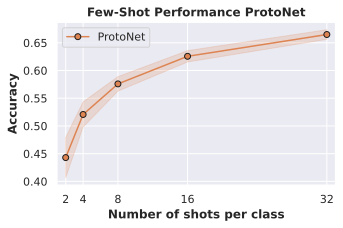

In [24]:
ax = plot_few_shot(protonet_accuracies, name="ProtoNet", color="C1")
plt.show()
plt.close()

As we initially expected, the performance of ProtoNet indeed increases the more samples we have.
However, even with just two samples per class, we classify almost half of the images correctly, which is well above random accuracy (10%).
The curve shows an exponentially dampend trend, meaning that adding 2 extra examples to $k=2$ has a much higher impact than adding 2 extra samples if we already have $k=16$.
Nonetheless, we can say that ProtoNet adapts fairly well to new classes.

## MAML and ProtoMAML

The second meta-learning algorithm we will look at is MAML, short for Model-Agnostic Meta-Learning.
MAML is an optimization-based meta-learning algorithm, which means that it tries to adjust the standard optimization procedure to a few-shot setting.
The idea of MAML is relatively simple: given a model, support and query set during training, we optimize the model for $m$ steps on the support set, and evaluate the gradients of the query loss with respect to the original model's parameters.
For the same model, we do it for a few different support-query sets and accumulate the gradients.
This results in learning a model that provides a good initialization for being quickly adapted to the training tasks.
If we denote the model parameters with $\theta$, we can visualize the procedure as follows (Figure credit - [Finn et al. ](http://proceedings.mlr.press/v70/finn17a.html)).

<center width="100%"><img src="https://github.com/PyTorchLightning/lightning-tutorials/raw/main/course_UvA-DL/meta-learning/MAML_figure.svg" width="300px"></center>

The full algorithm of MAML is therefore as follows.
At each training step, we sample a batch of tasks, i.e., a batch of support-query set pairs.
For each task $\mathcal{T}_i$, we optimize a model $f_{\theta}$ on the support set via SGD, and denote this model as $f_{\theta_i'}$.
We refer to this optimization as _inner loop_.
Using this new model, we calculate the gradients of the original parameters, $\theta$, with respect to the query loss on $f_{\theta_i'}$.
These gradients are accumulated over all tasks, and used to update $\theta$.
This is called _outer loop_ since we iterate over tasks.
The full MAML algorithm is summarized below (Figure credit - [Finn et al. ](http://proceedings.mlr.press/v70/finn17a.html)).

<center width="100%"><img src="https://github.com/PyTorchLightning/lightning-tutorials/raw/main/course_UvA-DL/meta-learning/MAML_algorithm.svg" width="400px"></center>

To obtain gradients for the initial parameters $\theta$ from the optimized model $f_{\theta_i'}$, we actually need second-order gradients, i.e. gradients of gradients, as the support set gradients depend on $\theta$ as well.
This makes MAML computationally expensive, especially when using mulitple inner loop steps.
A simpler, yet almost equally well performing alternative is First-Order MAML (FOMAML) which only uses first-order gradients.
This means that the second-order gradients are ignored, and we can calculate the outer loop gradients (line 10 in algorithm 2) simply by calculating the gradients with respect to $\theta_i'$, and use those as update to $\theta$.
Hence, the new update rule becomes:
$$\theta\leftarrow\theta-\beta\sum_{\mathcal{T}_i\sim p(\mathcal{T})}\nabla_{\theta_i'}\mathcal{L}_{\mathcal{T}_i}(f_{\theta_i'})$$
Note the change of $\theta$ to $\theta_i'$ for $\nabla$.

### ProtoMAML

A problem of MAML is how to design the output classification layer.
In case all tasks have different number of classes, we need to initialize the output layer with zeros or randomly in every iteration.
Even if we always have the same number of classes, we just start from random predictions.
This requires several inner loop steps to reach a reasonable classification result.
To overcome this problem, Triantafillou et al.
(2020) propose to combine the merits of Prototypical Networks and MAML.
Specifically, we can use prototypes to initialize our output layer to have a strong initialization.
Thereby, it can be shown that the softmax over euclidean distances can be reformulated as a linear layer with softmax.
To see this, let's first write out the negative euclidean distance between a feature vector $f_{\theta}(\mathbf{x}^{*})$ of a new data point $\mathbf{x}^{*}$ to a prototype $\mathbf{v}_c$ of class $c$:
$$
-||f_{\theta}(\mathbf{x}^{*})-\mathbf{v}_c||^2=-f_{\theta}(\mathbf{x}^{*})^Tf_{\theta}(\mathbf{x}^{*})+2\mathbf{v}_c^{T}f_{\theta}(\mathbf{x}^{*})-\mathbf{v}_c^T\mathbf{v}_c
$$

We perform the classification across all classes $c\in\mathcal{C}$ and take a softmax on the distance.
Hence, any term that is same for all classes can be removed without changing the output probabilities.
In the equation above, this is true for $-f_{\theta}(\mathbf{x}^{*})^Tf_{\theta}(\mathbf{x}^{*})$ since it is independent of any class prototype.
Thus, we can write:

$$
-||f_{\theta}(\mathbf{x}^{*})-\mathbf{v}_c||^2=2\mathbf{v}_c^{T}f_{\theta}(\mathbf{x}^{*})-||\mathbf{v}_c||^2+\text{constant}
$$

Taking a second look at the equation above, it looks a lot like a linear layer.
For this, we use $\mathbf{W}_{c,\cdot}=2\mathbf{v}_c$ and $b_c=-||\mathbf{v}_c||^2$ which gives us the linear layer $\mathbf{W}f_{\theta}(\mathbf{x}^{*})+\mathbf{b}$.
Hence, if we initialize the output weight with twice the prototypes, and the biases by the negative squared L2 norm of the prototypes, we start with a Prototypical Network.
MAML allows us to adapt this layer and the rest of the network further.

In the following, we will implement First-Order ProtoMAML for few-shot classification.
The implementation of MAML would be the same except the output layer initialization.

### ProtoMAML implementation

For implementing ProtoMAML, we can follow Algorithm 2 with minor modifications.
At each training step, we first sample a batch of tasks, and a support and query set for each task.
In our case of few-shot classification, this means that we simply sample multiple support-query set pairs from our sampler.
For each task, we finetune our current model on the support set.
However, since we need to remember the original parameters for the other tasks, the outer loop gradient update and future training steps, we need to create a copy of our model, and finetune only the copy.
We can copy a model by using standard Python functions like `deepcopy`.
The inner loop is implemented in the function `adapt_few_shot` in the PyTorch Lightning module below.

After finetuning the model, we apply it on the query set and calculate the first-order gradients with respect to the original parameters $\theta$.
In contrast to simple MAML, we also have to consider the gradients with respect to the output layer initialization, i.e. the prototypes, since they directly rely on $\theta$.
To realize this efficiently, we take two steps.
First, we calculate the prototypes by applying the original model, i.e. not the copied model, on the support elements.
When initializing the output layer, we detach the prototypes to stop the gradients.
This is because in the inner loop itself, we do not want to consider gradients through the prototypes back to the original model.
However, after the inner loop is finished, we re-attach the computation graph of the prototypes by writing `output_weight = (output_weight - init_weight).detach() + init_weight`.
While this line does not change the value of the variable `output_weight`, it adds its dependency on the prototype initialization `init_weight`.
Thus, if we call `.backward` on `output_weight`, we will automatically calculate the first-order gradients with respect to the prototype initialization in the original model.

After calculating all gradients and summing them together in the original model, we can take a standard optimizer step.
PyTorch Lightning's method is however designed to return a loss-tensor on which we call `.backward` first.
Since this is not possible here, we need to perform the optimization step ourselves.
All details can be found in the code below.

For implementing (Proto-)MAML with second-order gradients, it is recommended to use libraries such as [$\nabla$higher](https://github.com/facebookresearch/higher) from Facebook AI Research.
For simplicity, we stick with first-order methods here.

In [25]:
class ProtoMAML(pl.LightningModule):
    def __init__(self, proto_dim, lr, lr_inner, lr_output, num_inner_steps):
        """Inputs.

        proto_dim - Dimensionality of prototype feature space
        lr - Learning rate of the outer loop Adam optimizer
        lr_inner - Learning rate of the inner loop SGD optimizer
        lr_output - Learning rate for the output layer in the inner loop
        num_inner_steps - Number of inner loop updates to perform
        """
        super().__init__()
        self.save_hyperparameters()
        self.model = get_convnet(output_size=self.hparams.proto_dim)

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.hparams.lr)
        scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[140, 180], gamma=0.1)
        return [optimizer], [scheduler]

    def run_model(self, local_model, output_weight, output_bias, imgs, labels):
        # Execute a model with given output layer weights and inputs
        feats = local_model(imgs)
        preds = F.linear(feats, output_weight, output_bias)
        loss = F.cross_entropy(preds, labels)
        acc = (preds.argmax(dim=1) == labels).float()
        return loss, preds, acc

    def adapt_few_shot(self, support_imgs, support_targets):
        # Determine prototype initialization
        support_feats = self.model(support_imgs)
        prototypes, classes = ProtoNet.calculate_prototypes(support_feats, support_targets)
        support_labels = (classes[None, :] == support_targets[:, None]).long().argmax(dim=-1)
        # Create inner-loop model and optimizer
        local_model = deepcopy(self.model)
        local_model.train()
        local_optim = optim.SGD(local_model.parameters(), lr=self.hparams.lr_inner)
        local_optim.zero_grad()
        # Create output layer weights with prototype-based initialization
        init_weight = 2 * prototypes
        init_bias = -torch.norm(prototypes, dim=1) ** 2
        output_weight = init_weight.detach().requires_grad_()
        output_bias = init_bias.detach().requires_grad_()

        # Optimize inner loop model on support set
        for _ in range(self.hparams.num_inner_steps):
            # Determine loss on the support set
            loss, _, _ = self.run_model(local_model, output_weight, output_bias, support_imgs, support_labels)
            # Calculate gradients and perform inner loop update
            loss.backward()
            local_optim.step()
            # Update output layer via SGD
            output_weight.data -= self.hparams.lr_output * output_weight.grad
            output_bias.data -= self.hparams.lr_output * output_bias.grad
            # Reset gradients
            local_optim.zero_grad()
            output_weight.grad.fill_(0)
            output_bias.grad.fill_(0)

        # Re-attach computation graph of prototypes
        output_weight = (output_weight - init_weight).detach() + init_weight
        output_bias = (output_bias - init_bias).detach() + init_bias

        return local_model, output_weight, output_bias, classes

    def outer_loop(self, batch, mode="train"):
        accuracies = []
        losses = []
        self.model.zero_grad()

        # Determine gradients for batch of tasks
        for task_batch in batch:
            imgs, targets = task_batch
            support_imgs, query_imgs, support_targets, query_targets = split_batch(imgs, targets)
            # Perform inner loop adaptation
            local_model, output_weight, output_bias, classes = self.adapt_few_shot(support_imgs, support_targets)
            # Determine loss of query set
            query_labels = (classes[None, :] == query_targets[:, None]).long().argmax(dim=-1)
            loss, preds, acc = self.run_model(local_model, output_weight, output_bias, query_imgs, query_labels)
            # Calculate gradients for query set loss
            if mode == "train":
                loss.backward()

                for p_global, p_local in zip(self.model.parameters(), local_model.parameters()):
                    p_global.grad += p_local.grad  # First-order approx. -> add gradients of finetuned and base model

            accuracies.append(acc.mean().detach())
            losses.append(loss.detach())

        # Perform update of base model
        if mode == "train":
            opt = self.optimizers()
            opt.step()
            opt.zero_grad()

        self.log("%s_loss" % mode, sum(losses) / len(losses))
        self.log("%s_acc" % mode, sum(accuracies) / len(accuracies))

    def training_step(self, batch, batch_idx):
        self.outer_loop(batch, mode="train")
        return None  # Returning None means we skip the default training optimizer steps by PyTorch Lightning

    def validation_step(self, batch, batch_idx):
        # Validation requires to finetune a model, hence we need to enable gradients
        torch.set_grad_enabled(True)
        self.outer_loop(batch, mode="val")
        torch.set_grad_enabled(False)

### Training

To train ProtoMAML, we need to change our sampling slightly.
Instead of a single support-query set batch, we need to sample multiple.
To implement this, we yet use another Sampler which combines multiple batches from a `FewShotBatchSampler`, and returns it afterwards.
Additionally, we define a `collate_fn` for our data loader which takes the stack of support-query set images, and returns the tasks as a list.
This makes it easier to process in our PyTorch Lightning module before.
The implementation of the sampler can be found below.

In [26]:
class TaskBatchSampler:
    def __init__(self, dataset_targets, batch_size, N_way, K_shot, include_query=False, shuffle=True):
        """
        Inputs:
            dataset_targets - PyTorch tensor of the labels of the data elements.
            batch_size - Number of tasks to aggregate in a batch
            N_way - Number of classes to sample per batch.
            K_shot - Number of examples to sample per class in the batch.
            include_query - If True, returns batch of size N_way*K_shot*2, which
                            can be split into support and query set. Simplifies
                            the implementation of sampling the same classes but
                            distinct examples for support and query set.
            shuffle - If True, examples and classes are newly shuffled in each
                      iteration (for training)
        """
        super().__init__()
        self.batch_sampler = FewShotBatchSampler(dataset_targets, N_way, K_shot, include_query, shuffle)
        self.task_batch_size = batch_size
        self.local_batch_size = self.batch_sampler.batch_size

    def __iter__(self):
        # Aggregate multiple batches before returning the indices
        batch_list = []
        for batch_idx, batch in enumerate(self.batch_sampler):
            batch_list.extend(batch)
            if (batch_idx + 1) % self.task_batch_size == 0:
                yield batch_list
                batch_list = []

    def __len__(self):
        return len(self.batch_sampler) // self.task_batch_size

    def get_collate_fn(self):
        # Returns a collate function that converts one big tensor into a list of task-specific tensors
        def collate_fn(item_list):
            imgs = torch.stack([img for img, target in item_list], dim=0)
            targets = torch.stack([target for img, target in item_list], dim=0)
            imgs = imgs.chunk(self.task_batch_size, dim=0)
            targets = targets.chunk(self.task_batch_size, dim=0)
            return list(zip(imgs, targets))

        return collate_fn

The creation of the data loaders is with this sampler straight-forward.
Note that since many images need to loaded for a training batch, it is recommended to use less workers than usual.

In [27]:
# Training constant (same as for ProtoNet)
N_WAY = 5
K_SHOT = 4

# Training set
train_protomaml_sampler = TaskBatchSampler(
    train_set.targets, include_query=True, N_way=N_WAY, K_shot=K_SHOT, batch_size=16
)
train_protomaml_loader = data.DataLoader(
    train_set, batch_sampler=train_protomaml_sampler, collate_fn=train_protomaml_sampler.get_collate_fn(), num_workers=2
)

# Validation set
val_protomaml_sampler = TaskBatchSampler(
    val_set.targets,
    include_query=True,
    N_way=N_WAY,
    K_shot=K_SHOT,
    batch_size=1,  # We do not update the parameters, hence the batch size is irrelevant here
    shuffle=False,
)
val_protomaml_loader = data.DataLoader(
    val_set, batch_sampler=val_protomaml_sampler, collate_fn=val_protomaml_sampler.get_collate_fn(), num_workers=2
)

Now, we are ready to train our ProtoMAML.
We use the same feature space size as for ProtoNet, but can use a higher learning rate since the outer loop gradients are accumulated over 16 batches.
The inner loop learning rate is set to 0.1, which is much higher than the outer loop lr because we use SGD in the inner loop instead of Adam.
Commonly, the learning rate for the output layer is higher than the base model is the base model is very deep or pre-trained.
However, for our setup, we observed no noticable impact of using a different learning rate than the base model.
The number of inner loop updates is another crucial hyperparmaeter, and depends on the similarity of our training tasks.
Since all tasks are on images from the same dataset, we notice that a single inner loop update achieves similar performance as 3 or 5 while training considerably faster.
However, especially in RL and NLP, larger number of inner loop steps are often needed.

In [28]:
protomaml_model = train_model(
    ProtoMAML,
    proto_dim=64,
    lr=1e-3,
    lr_inner=0.1,
    lr_output=0.1,
    num_inner_steps=1,  # Often values between 1 and 10
    train_loader=train_protomaml_loader,
    val_loader=val_protomaml_loader,
)

GPU available: True, used: True


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


Found pretrained model at saved_models/MetaLearning/ProtoMAML.ckpt, loading...


Let's have a look at the training TensorBoard.

In [29]:
# Opens tensorboard in notebook. Adjust the path to your CHECKPOINT_PATH if needed
# # %tensorboard --logdir ../saved_models/tutorial16/tensorboards/ProtoMAML/

<center width="100%"><img src="https://github.com/PyTorchLightning/lightning-tutorials/raw/main/course_UvA-DL/meta-learning/tensorboard_screenshot_ProtoMAML.png" width="1100px"></center>

One obvious difference to ProtoNet is that the loss curves look much less noisy.
This is because we average the outer loop gradients over multiple tasks, and thus have a smoother training curve.
Additionally, we only have 15k training iterations after 200 epochs.
This is again because of the task batches, which cause 16 times less iterations.
However, each iteration has seen 16 times more data in this experiment.
Thus, we still have a fair comparison between ProtoMAML and ProtoNet.
At first sight on the validation accuracy, one would assume that
ProtoNet performs superior to ProtoMAML, but we have to verify that with
proper testing below.

### Testing

We test ProtoMAML in the same manner as ProtoNet, namely by picking random examples in the test set as support sets and use the rest of the dataset as query set.
Instead of just calculating the prototypes for all examples, we need to finetune a separate model for each support set.
This is why this process is more expensive than ProtoNet, and in our case, testing $k=\{2,4,8,16,32\}$ can take almost an hour.
Hence, we provide evaluation files besides the pretrained models.

In [30]:
def test_protomaml(model, dataset, k_shot=4):
    pl.seed_everything(42)
    model = model.to(device)
    num_classes = dataset.targets.unique().shape[0]

    # Data loader for full test set as query set
    full_dataloader = data.DataLoader(dataset, batch_size=128, num_workers=4, shuffle=False, drop_last=False)
    # Data loader for sampling support sets
    sampler = FewShotBatchSampler(
        dataset.targets, include_query=False, N_way=num_classes, K_shot=k_shot, shuffle=False, shuffle_once=False
    )
    sample_dataloader = data.DataLoader(dataset, batch_sampler=sampler, num_workers=2)

    # We iterate through the full dataset in two manners. First, to select the k-shot batch.
    # Second, the evaluate the model on all other examples
    accuracies = []
    for (support_imgs, support_targets), support_indices in tqdm(
        zip(sample_dataloader, sampler), "Performing few-shot finetuning"
    ):
        support_imgs = support_imgs.to(device)
        support_targets = support_targets.to(device)
        # Finetune new model on support set
        local_model, output_weight, output_bias, classes = model.adapt_few_shot(support_imgs, support_targets)
        with torch.no_grad():  # No gradients for query set needed
            local_model.eval()
            batch_acc = torch.zeros((0,), dtype=torch.float32, device=device)
            # Evaluate all examples in test dataset
            for query_imgs, query_targets in full_dataloader:
                query_imgs = query_imgs.to(device)
                query_targets = query_targets.to(device)
                query_labels = (classes[None, :] == query_targets[:, None]).long().argmax(dim=-1)
                _, _, acc = model.run_model(local_model, output_weight, output_bias, query_imgs, query_labels)
                batch_acc = torch.cat([batch_acc, acc.detach()], dim=0)
            # Exclude support set elements
            for s_idx in support_indices:
                batch_acc[s_idx] = 0
            batch_acc = batch_acc.sum().item() / (batch_acc.shape[0] - len(support_indices))
            accuracies.append(batch_acc)
    return mean(accuracies), stdev(accuracies)

In contrast to training, it is recommended to use many more inner loop updates during testing.
During training, we are not interested in getting the best model from the inner loop, but the model which can provide the best gradients.
Hence, one update might be already sufficient in training, but for testing, it was often observed that larger number of updates can give a considerable performance boost.
Thus, we change the inner loop updates to 200 before testing.

In [31]:
protomaml_model.hparams.num_inner_steps = 200

Now, we can test our model.
For the pre-trained models, we provide a json file with the results to reduce evaluation time.

In [32]:
protomaml_result_file = os.path.join(CHECKPOINT_PATH, "protomaml_fewshot.json")

if os.path.isfile(protomaml_result_file):
    # Load pre-computed results
    with open(protomaml_result_file) as f:
        protomaml_accuracies = json.load(f)
    protomaml_accuracies = {int(k): v for k, v in protomaml_accuracies.items()}
else:
    # Perform same experiments as for ProtoNet
    protomaml_accuracies = dict()
    for k in [2, 4, 8, 16, 32]:
        protomaml_accuracies[k] = test_protomaml(protomaml_model, test_set, k_shot=k)
    # Export results
    with open(protomaml_result_file, "w") as f:
        json.dump(protomaml_accuracies, f, indent=4)

for k in protomaml_accuracies:
    print(
        "Accuracy for k=%i: %4.2f%% (+-%4.2f%%)"
        % (k, 100.0 * protomaml_accuracies[k][0], 100.0 * protomaml_accuracies[k][1])
    )

Accuracy for k=2: 42.89% (+-3.82%)
Accuracy for k=4: 52.27% (+-2.72%)
Accuracy for k=8: 59.23% (+-1.50%)
Accuracy for k=16: 63.94% (+-1.24%)
Accuracy for k=32: 67.57% (+-0.90%)


Again, let's plot the results in our plot from before.

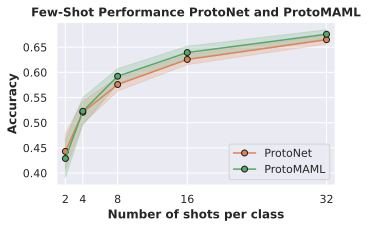

In [33]:
ax = plot_few_shot(protonet_accuracies, name="ProtoNet", color="C1")
plot_few_shot(protomaml_accuracies, name="ProtoMAML", color="C2", ax=ax)
plt.show()
plt.close()

We can observe that ProtoMAML is indeed able to outperform ProtoNet for $k>4$.
This is because with more samples, it becomes more relevant to also adapt the base model's parameters.
Meanwhile, for $k=2$, ProtoMAML achieves lower performance than ProtoNet.
This is likely also related to choosing 200 inner loop updates since with more updates, there exists the risk of overfitting.
Nonetheless, the high standard deviation for $k=2$ makes it hard to take any statistically valid conclusion.

Overall, we can conclude that ProtoMAML slightly outperforms ProtoNet for larger shot counts.
However, one disadvantage of ProtoMAML is its much longer training and testing time.
ProtoNet provides a simple, efficient, yet strong baseline for
ProtoMAML, and might be the better solution in situations where limited
resources are available.

## Domain adaptation

So far, we have evaluated our meta-learning algorithms on the same dataset on which we have trained them.
However, meta-learning algorithms are especially interesting when we want to move from one to another dataset.
So, what happens if we apply them on a quite different dataset than CIFAR?
This is what we try out below, and evaluate ProtoNet and ProtoMAML on the SVHN dataset.

### SVHN dataset

The Street View House Numbers (SVHN) dataset is a real-world image dataset for house number detection.
It is similar to MNIST by having the classes 0 to 9, but is more difficult due to its real-world setting and possible distracting numbers left and right.
Let's first load the dataset, and visualize some images to get an impression of the dataset.

In [34]:
SVHN_test_dataset = SVHN(root=DATASET_PATH, split="test", download=True, transform=transforms.ToTensor())

  0%|          | 0/64275384 [00:00<?, ?it/s]

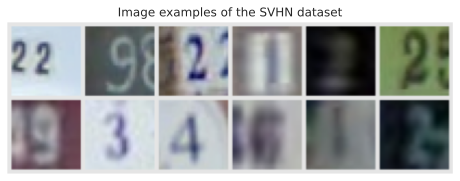

In [35]:
# Visualize some examples
NUM_IMAGES = 12
SVHN_images = [SVHN_test_dataset[np.random.randint(len(SVHN_test_dataset))][0] for idx in range(NUM_IMAGES)]
SVHN_images = torch.stack(SVHN_images, dim=0)
img_grid = torchvision.utils.make_grid(SVHN_images, nrow=6, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8, 8))
plt.title("Image examples of the SVHN dataset")
plt.imshow(img_grid)
plt.axis("off")
plt.show()
plt.close()

Each image is labeled with one class between 0 and 9 representing the main digit in the image.
Can our ProtoNet and ProtoMAML learn to classify the digits from only a few examples?
This is what we will test out below.
The images have the same size as CIFAR, so that we can use the images without changes.
We first prepare the dataset, for which we take the first 500 images per class.
For this dataset, we use our test functions as before to get an estimated performance for different number of shots.

In [36]:
imgs = np.transpose(SVHN_test_dataset.data, (0, 2, 3, 1))
targets = SVHN_test_dataset.labels
# Limit number of examples to 500 to reduce test time
min_label_count = min(500, np.bincount(SVHN_test_dataset.labels).min())

idxs = np.concatenate([np.where(targets == c)[0][:min_label_count] for c in range(1 + targets.max())], axis=0)
imgs = imgs[idxs]
targets = torch.from_numpy(targets[idxs]).long()

svhn_fewshot_dataset = ImageDataset(imgs, targets, img_transform=test_transform)
svhn_fewshot_dataset.imgs.shape

(5000, 32, 32, 3)

### Experiments

First, we can apply ProtoNet to the SVHN dataset:

In [37]:
protonet_svhn_accuracies = dict()
data_feats = None
for k in [2, 4, 8, 16, 32]:
    protonet_svhn_accuracies[k], data_feats = test_proto_net(
        protonet_model, svhn_fewshot_dataset, data_feats=data_feats, k_shot=k
    )
    print(
        "Accuracy for k=%i: %4.2f%% (+-%4.2f%%)"
        % (k, 100.0 * protonet_svhn_accuracies[k][0], 100 * protonet_svhn_accuracies[k][1])
    )

Extracting image features:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating prototype classification:   0%|          | 0/250 [00:00<?, ?it/s]

Accuracy for k=2: 18.82% (+-2.28%)


Evaluating prototype classification:   0%|          | 0/125 [00:00<?, ?it/s]

Accuracy for k=4: 21.94% (+-2.09%)


Evaluating prototype classification:   0%|          | 0/63 [00:00<?, ?it/s]

Accuracy for k=8: 25.59% (+-1.76%)


Evaluating prototype classification:   0%|          | 0/32 [00:00<?, ?it/s]

Accuracy for k=16: 29.06% (+-1.84%)


Evaluating prototype classification:   0%|          | 0/16 [00:00<?, ?it/s]

Accuracy for k=32: 32.93% (+-1.33%)


It becomes clear that the results are much lower than the ones on CIFAR, and just slightly above random for $k=2$.
How about ProtoMAML?
We provide again evaluation files since the evaluation can take several minutes to complete.

In [38]:
protomaml_result_file = os.path.join(CHECKPOINT_PATH, "protomaml_svhn_fewshot.json")

if os.path.isfile(protomaml_result_file):
    # Load pre-computed results
    with open(protomaml_result_file) as f:
        protomaml_svhn_accuracies = json.load(f)
    protomaml_svhn_accuracies = {int(k): v for k, v in protomaml_svhn_accuracies.items()}
else:
    # Perform same experiments as for ProtoNet
    protomaml_svhn_accuracies = dict()
    for k in [2, 4, 8, 16, 32]:
        protomaml_svhn_accuracies[k] = test_protomaml(protomaml_model, svhn_fewshot_dataset, k_shot=k)
    # Export results
    with open(protomaml_result_file, "w") as f:
        json.dump(protomaml_svhn_accuracies, f, indent=4)

for k in protomaml_svhn_accuracies:
    print(
        "Accuracy for k=%i: %4.2f%% (+-%4.2f%%)"
        % (k, 100.0 * protomaml_svhn_accuracies[k][0], 100.0 * protomaml_svhn_accuracies[k][1])
    )

Accuracy for k=2: 17.11% (+-1.95%)
Accuracy for k=4: 21.29% (+-1.92%)
Accuracy for k=8: 27.62% (+-1.84%)
Accuracy for k=16: 36.17% (+-1.80%)
Accuracy for k=32: 46.03% (+-1.65%)


While ProtoMAML shows similar performance than ProtoNet for $k\leq 4$, it considerably outperforms ProtoNet for more than 8 shots.
This is because we can adapt the base model, which is crucial when the data does not fit the original training data.
For $k=32$, ProtoMAML achieves $13\%$ higher classification accuracy than ProtoNet which already starts to flatten out.
We can see the trend more clearly in our plot below.

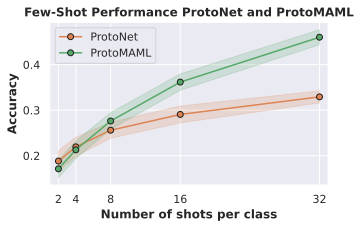

In [39]:
ax = plot_few_shot(protonet_svhn_accuracies, name="ProtoNet", color="C1")
plot_few_shot(protomaml_svhn_accuracies, name="ProtoMAML", color="C2", ax=ax)
plt.show()
plt.close()

## Conclusion

In this notebook, we have discussed meta-learning algorithms that learn to adapt to new classes and/or tasks with just a few samples.
We have discussed three popular algorithms, namely ProtoNet, MAML and ProtoMAML.
On the few-shot image classification task of CIFAR100, ProtoNet and ProtoMAML showed to perform similarly well, with slight benefits of ProtoMAML for larger shot sizes.
However, for out-of-distribution data (SVHN), the ability to optimize the base model showed to be crucial and gave ProtoMAML considerable performance gains over ProtoNet.
Nonetheless, ProtoNet offers other advantages compared to ProtoMAML, namely a very cheap training and test cost as well as a simpler implementation.
Hence, it is recommended to consider whether the additionally complexity
of ProtoMAML is worth the extra training computation cost, or whether
ProtoNet is already sufficient for the task at hand.

### References

[1] Snell, Jake, Kevin Swersky, and Richard S. Zemel.
"Prototypical networks for few-shot learning."
NeurIPS 2017.
([link](https://arxiv.org/pdf/1703.05175.pdf))

[2] Chelsea Finn, Pieter Abbeel, Sergey Levine.
"Model-Agnostic Meta-Learning for Fast Adaptation of Deep Networks."
ICML 2017.
([link](http://proceedings.mlr.press/v70/finn17a.html))

[3] Triantafillou, Eleni, Tyler Zhu, Vincent Dumoulin, Pascal Lamblin, Utku Evci, Kelvin Xu, Ross Goroshin et al.
"Meta-dataset: A dataset of datasets for learning to learn from few examples."
ICLR 2020.
([link](https://openreview.net/pdf?id=rkgAGAVKPr))

## Congratulations - Time to Join the Community!

Congratulations on completing this notebook tutorial! If you enjoyed this and would like to join the Lightning
movement, you can do so in the following ways!

### Star [Lightning](https://github.com/PyTorchLightning/pytorch-lightning) on GitHub
The easiest way to help our community is just by starring the GitHub repos! This helps raise awareness of the cool
tools we're building.

### Join our [Slack](https://join.slack.com/t/pytorch-lightning/shared_invite/zt-pw5v393p-qRaDgEk24~EjiZNBpSQFgQ)!
The best way to keep up to date on the latest advancements is to join our community! Make sure to introduce yourself
and share your interests in `#general` channel


### Contributions !
The best way to contribute to our community is to become a code contributor! At any time you can go to
[Lightning](https://github.com/PyTorchLightning/pytorch-lightning) or [Bolt](https://github.com/PyTorchLightning/lightning-bolts)
GitHub Issues page and filter for "good first issue".

* [Lightning good first issue](https://github.com/PyTorchLightning/pytorch-lightning/issues?q=is%3Aopen+is%3Aissue+label%3A%22good+first+issue%22)
* [Bolt good first issue](https://github.com/PyTorchLightning/lightning-bolts/issues?q=is%3Aopen+is%3Aissue+label%3A%22good+first+issue%22)
* You can also contribute your own notebooks with useful examples !

### Great thanks from the entire Pytorch Lightning Team for your interest !

Pytorch Lightning{height="60px" width="240px"}